# Enkel tijd (txxxxxx)

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

## Data Laden

In [2]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [3]:
columns_to_drop = ['TRYHHCHILD', 'TEAGE', 'TESEX','PEEDUCA', 'PTDTRACE', 'PEHSPNON', 'GTMETSTA',
'TELFS', 'TEMJOT', 'TRDPFTPT', 'TESCHENR', 'TESCHLVL', 'TRSPPRES', 'TESPEMPNOT', 'TRCHILDNUM', 'TRSPFTPT', 'TEHRUSLT', 'TUCASEID', 'TUFINLWGT', 'TRTEC', 'TRTHH']

asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.drop(columns_to_drop, axis=1)
df = df.fillna(0)

print(df.shape)
df.head()

(21361, 442)


,TRERNWA,TUDIARYDAY,TRHOLIDAY,t010101,t010102,t010201,t010299,t010301,t010399,t010401,...,t119999,t130115,t130123,t130399,t130402,t150899,t019999,t060402,t090302,t180599
3,469.44,1,0,635,0,20,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,302.50,1,0,500,0,80,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1538.46,1,0,778,0,60,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1211.53,6,0,480,0,75,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,961.53,7,0,625,0,45,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.drop(columns_to_drop, axis=1)
df2022 = df2022.fillna(0)

print(df2022.shape)
df2022.head()

(4226, 380)


,TRERNWA,TUDIARYDAY,TRHOLIDAY,t010101,t010102,t010201,t010299,t010301,t010399,t010401,...,t181599,t181601,t181801,t181899,t189999,t500101,t500103,t500105,t500106,t500107
1,640.00,5,0,540,0,70,0,330,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1750.00,1,0,540,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,769.23,1,0,90,0,2,0,1305,0,0,...,0,0,0,0,0,0,0,0,0,0
10,520.00,1,0,360,0,60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1615.38,7,0,360,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
kolommen_df1 = set(df.columns)
kolommen_df2 = set(df2022.columns)

ontbrekende_in_df1 = kolommen_df2 - kolommen_df1
ontbrekende_in_df2 = kolommen_df1 - kolommen_df2

print("Ontbrekende kolommen in df1:", ontbrekende_in_df1)
print("Ontbrekende kolommen in df2:", ontbrekende_in_df2)

for kolom in ontbrekende_in_df1:
    df[kolom] = 0

for kolom in ontbrekende_in_df2:
    df2022[kolom] = 0

print(df.shape)
print(df2022.shape)

# Juiste volgorde
alle_kolommen = sorted(list(kolommen_df1 | kolommen_df2))
df = df[alle_kolommen]
df2022 = df2022[alle_kolommen]

Ontbrekende kolommen in df1: {'t070299', 't090499', 't130111'}
Ontbrekende kolommen in df2: {'t109999', 't180199', 't050299', 't130115', 't020999', 't180499', 't150599', 't039999', 't070399', 't010199', 't130215', 't080299', 't129999', 't130401', 't049999', 't130231', 't080399', 't130135', 't181499', 't070301', 't050203', 't050404', 't119999', 't060403', 't100305', 't180399', 't130222', 't130402', 't181099', 't180799', 't130212', 't070199', 't080102', 't100401', 't169999', 't150799', 't079999', 't130214', 't080602', 't060204', 't100399', 't090402', 't060299', 't040399', 't130229', 't150899', 't130205', 't090199', 't180604', 't060402', 't130209', 't130399', 't130217', 't010501', 't080302', 't110299', 't050405', 't080801', 't100299', 't060303', 't020299', 't181699', 't020599', 't060104', 't130123'}
(21361, 445)
(4226, 445)


/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_39705/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[kolom] = 0
/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_39705/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[kolom] = 0
/var/folders/wq/9k50k0z17hj5h7vgt_4rdbwh0000gn/T/ipykernel_39705/3644154621.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

In [7]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

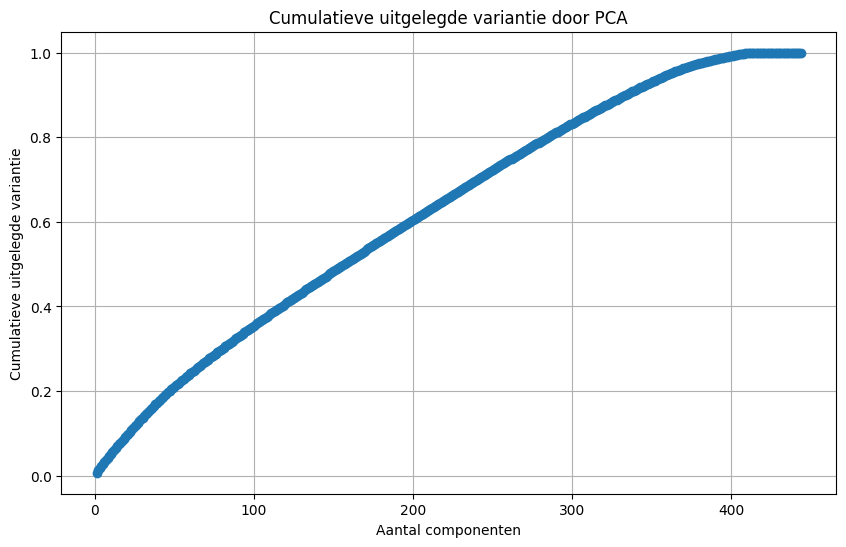

Aantal componenten dat 95% van de variantie verklaart: 362
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.103993  0.575678 -1.020662 -0.055342 -0.098082  0.226125 -0.016526   
1 -1.493118 -0.524052 -2.127718  0.040910 -0.052284  0.747140 -0.077022   
2  1.129316  0.426114 -1.275922  0.090462 -0.071215  0.713171 -0.026461   
3  0.232079  0.822693 -0.604608 -0.005865  0.097502 -0.307873 -0.092442   
4 -0.646549 -2.863043  0.865186  0.235825 -0.256166 -0.925346  0.122827   

        PC8       PC9      PC10  ...     PC354     PC355     PC356     PC357  \
0 -0.214263 -0.001882 -0.132271  ...  0.545036 -0.042629 -0.179004 -0.893451   
1 -0.421484  0.107734  0.115901  ...  0.973340 -0.614555  0.487448 -0.520788   
2 -0.566422  1.052671 -0.678466  ...  1.411660 -0.713803  0.274503 -0.952156   
3 -0.107362  0.216687 -0.044504  ...  1.767207 -1.098888  0.180889 -1.988834   
4  0.350990 -1.881339  0.264430  ...  0.831829  0.478684  0.452357 -0.800555   

      PC3

In [8]:
target_column = 'TRERNWA'
df_target = df[target_column]
df_features = df.drop(columns=[target_column])

df2022_target = df2022[target_column]
df2022_features = df2022.drop(columns=[target_column])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

df2022_scaled = scaler.transform(df2022_features)

pca = PCA()
principal_components = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance_cumsum = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_cumsum) + 1), explained_variance_cumsum, marker='o', linestyle='--')
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve uitgelegde variantie')
plt.title('Cumulatieve uitgelegde variantie door PCA')
plt.grid()
plt.show()

n_components = next(i for i, total_var in enumerate(explained_variance_cumsum) if total_var > 0.95) + 1
print(f'Aantal componenten dat 95% van de variantie verklaart: {n_components}')

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

df2022_pca = pca.transform(df2022_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca_df = pd.DataFrame(data=df_pca, columns=pca_columns)
df2022_pca_df = pd.DataFrame(data=df2022_pca, columns=pca_columns)

df_with_pca = pd.concat([df_pca_df, df_target.reset_index(drop=True)], axis=1)
df2022_with_pca = pd.concat([df2022_pca_df, df2022_target.reset_index(drop=True)], axis=1)

print(df2022_with_pca.head())

In [9]:
train_set, test_set = train_test_split(df_with_pca, test_size=0.2, random_state=10)

X_train_pca = train_set.drop("TRERNWA", axis=1)
y_train_pca = train_set["TRERNWA"]
X_test_pca = test_set.drop("TRERNWA", axis=1)
y_test_pca = test_set["TRERNWA"]

X_pca2022 = df2022_with_pca.drop("TRERNWA", axis=1)
y_pca2022 = df2022_with_pca["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 99339342333140.83
R2 Score: -3.2892451915654576e+25
______

2022 MAE: 1245811722889141.8
2022 R2 Score: -2.539849608443466e+27



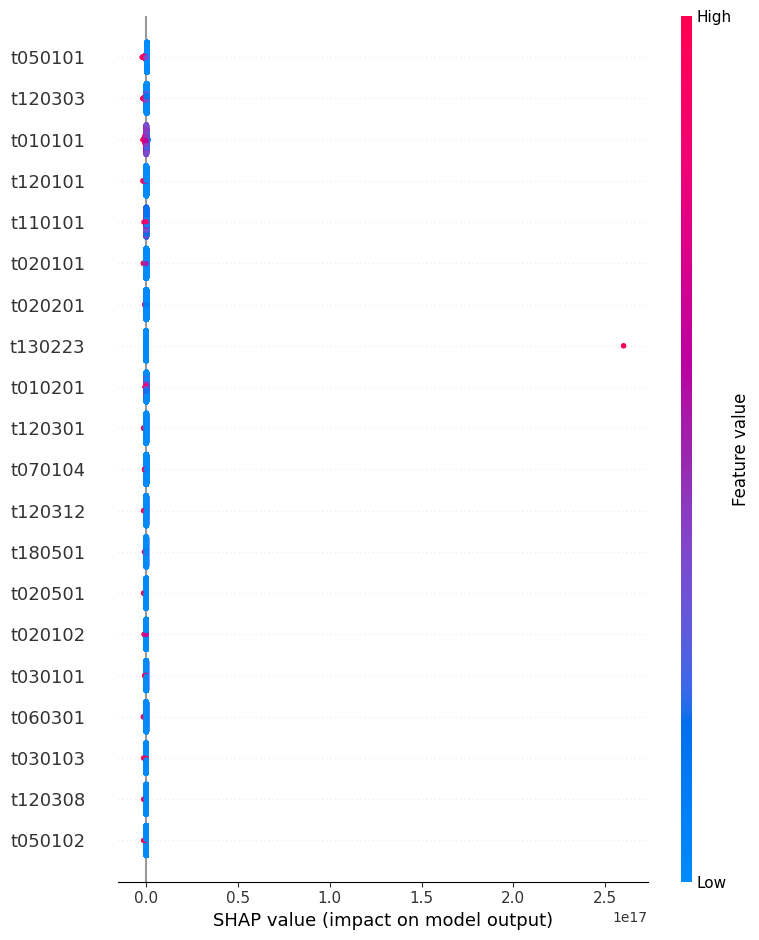

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### PCA


Test MAE: 584.2928509446085
R2 Score: -2.700393073008974
______

2022 MAE: 625.7021207162867
2022 R2 Score: -0.3281316483411809



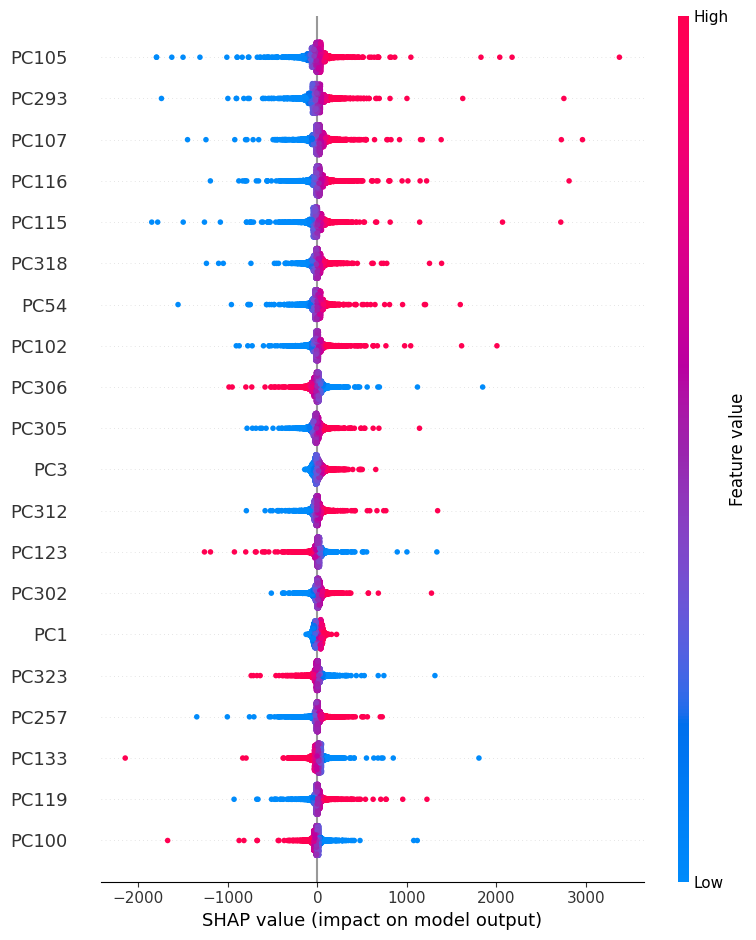

In [13]:
model = LinearRegression()
model.fit(X_train_pca, y_train_pca)

y_pred = model.predict(X_test_pca)
y_pred2022 = model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_pca)

shap_values_test = explainer.shap_values(X_test_pca)

shap.summary_plot(shap_values_test, X_test_pca, feature_names=X_train_pca.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 556.2479707888539
R2 Score: 0.06073638075867005
______

2022 MAE: 625.4612514852386
2022 R2 Score: -0.3559502222558919



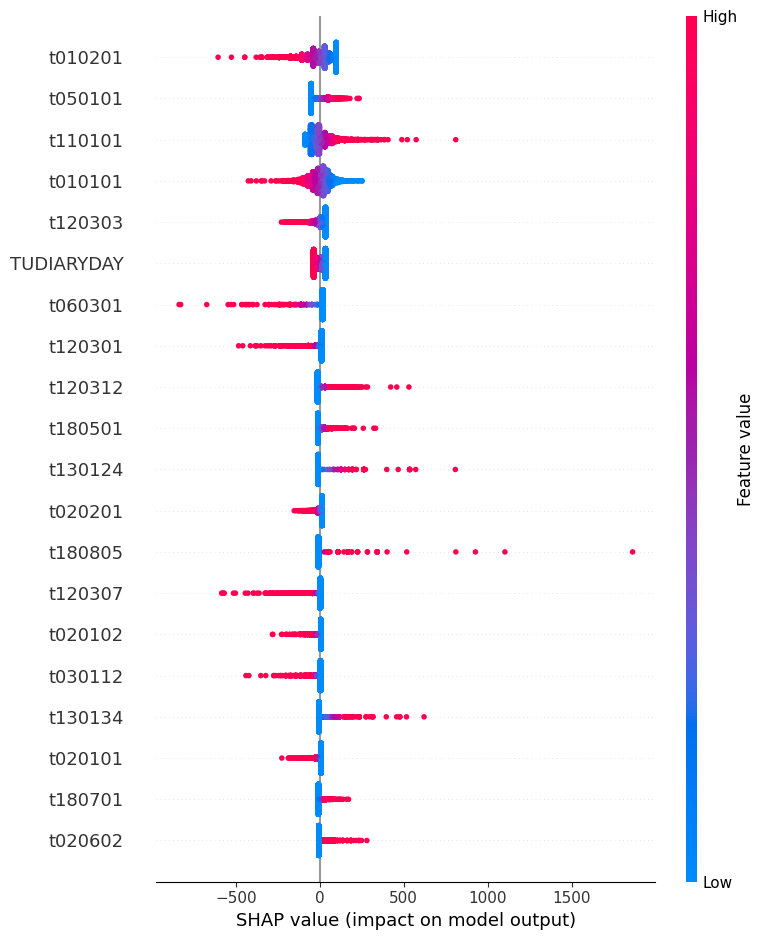

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### PCA

In [14]:
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = best_ridge_model.predict(X_test_pca)
y_pred2022 = best_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'alpha': 100.0}

Test MAE: 559.0144066806399
R2 Score: 0.024966467846593732
______

2022 MAE: 626.0856228797486
2022 R2 Score: -0.3400167098000073



#### Lasso Regressie

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+06, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.561e+06, tolerance: 7.525e+05
  model = cd_fast.enet_coordinate_descent(
/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Beste hyperparameters: {'alpha': 10.0}

Test MAE: 556.6013638323174
R2 Score: 0.09759084381746563
______

2022 MAE: 615.046826687786
2022 R2 Score: -0.0018001223065950978



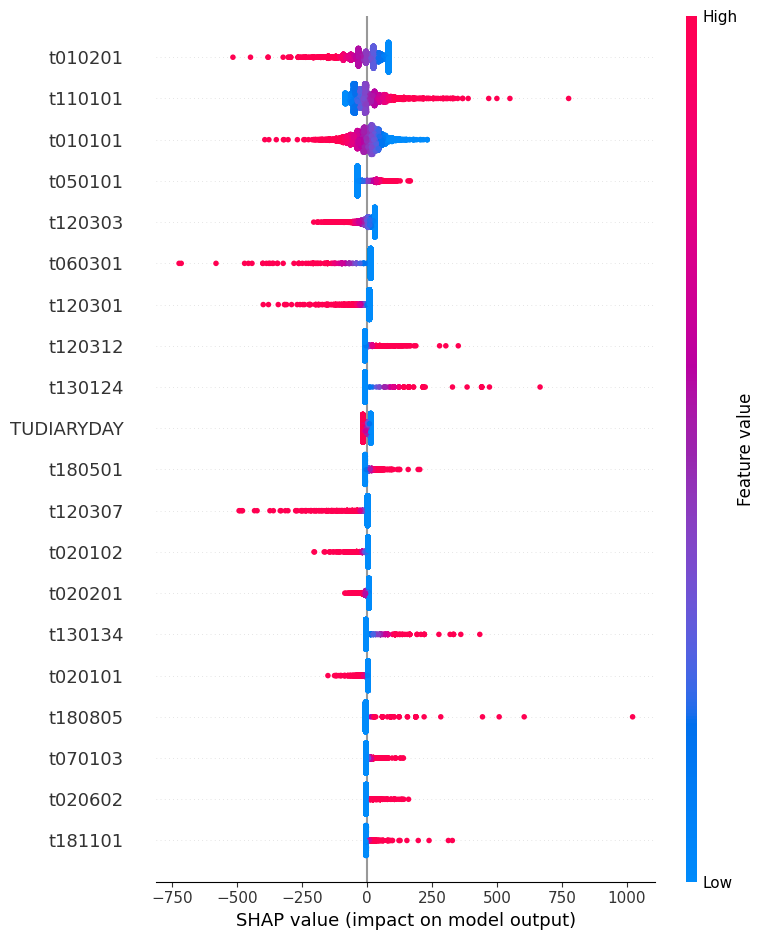

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### PCA

In [15]:
lasso_model = Lasso()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_pca, y_train_pca)

y_pred = best_lasso_model.predict(X_test_pca)
y_pred2022 = best_lasso_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.140e+06, tolerance: 7.528e+05
  model = cd_fast.enet_coordinate_descent(


Beste hyperparameters: {'alpha': 1.0}

Test MAE: 553.2432319667465
R2 Score: 0.08983529067846552
______

2022 MAE: 625.1083523288366
2022 R2 Score: -0.30940931432209484



#### Bayesian Ridge Regression


Test MAE: 555.9858517016781
R2 Score: 0.07855441675413988
______

2022 MAE: 622.3558392028996
2022 R2 Score: -0.23050824696595007



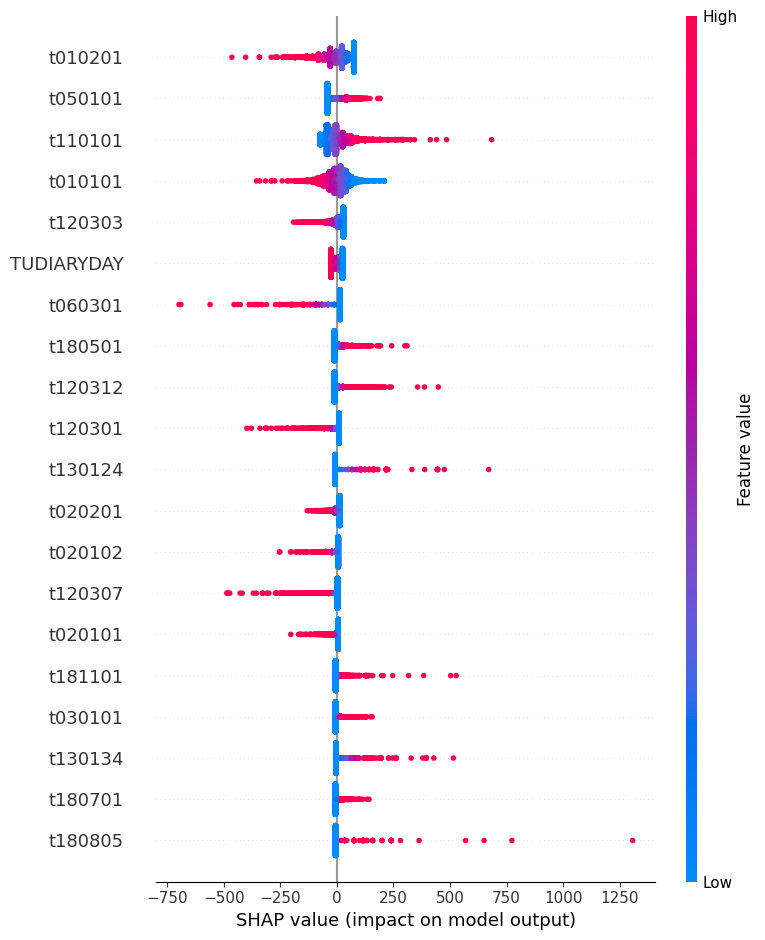

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### PCA

In [14]:
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_pca, y_train_pca)

y_pred = bayesian_ridge_model.predict(X_test_pca)
y_pred2022 = bayesian_ridge_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 553.0705253245403
R2 Score: 0.10108429037266742
______

2022 MAE: 623.5668598949661
2022 R2 Score: -0.2426092271766398



### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}

Test MAE: 564.7495646598187
R2 Score: 0.0739272428285308
______

2022 MAE: 628.7219948462596
2022 R2 Score: -0.03983763180531419



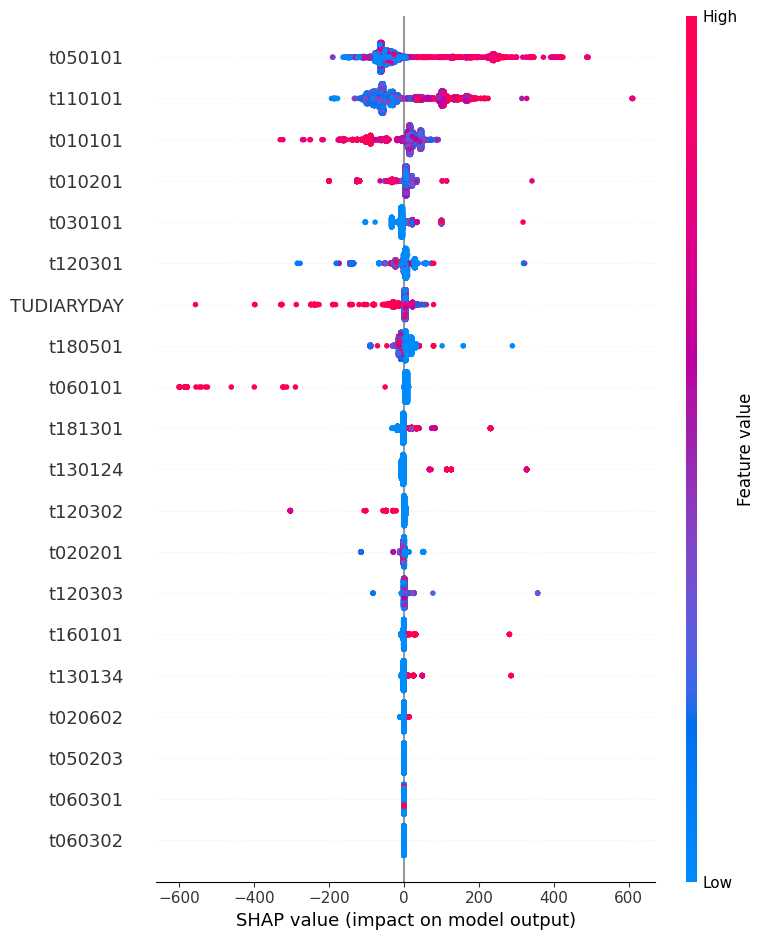

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

##### PCA

In [16]:
tree_model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_pca, y_train_pca)

y_pred = best_tree_model.predict(X_test_pca)
y_pred2022 = best_tree_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Test MAE: 573.4174952292839
R2 Score: 0.04585701013835819
______

2022 MAE: 630.3153826873381
2022 R2 Score: -0.05594244692104544



#### Random Forests

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Test MAE: 530.5579768153419
R2 Score: 0.1579476818080896
______

2022 MAE: 599.84938064538
2022 R2 Score: 0.03263827859636381



##### PCA

In [15]:
rf_model = RandomForestRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_pca, y_train_pca)

y_pred = best_rf_model.predict(X_test_pca)
y_pred2022 = best_rf_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 553.126933416416
R2 Score: 0.10821788346093253
______

2022 MAE: 616.0544228984161
2022 R2 Score: -0.006934767954189791



#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Test MAE: 519.9075404187272
R2 Score: 0.19285477152467512
______

2022 MAE: 586.1456728508746
2022 R2 Score: 0.07591966181977872



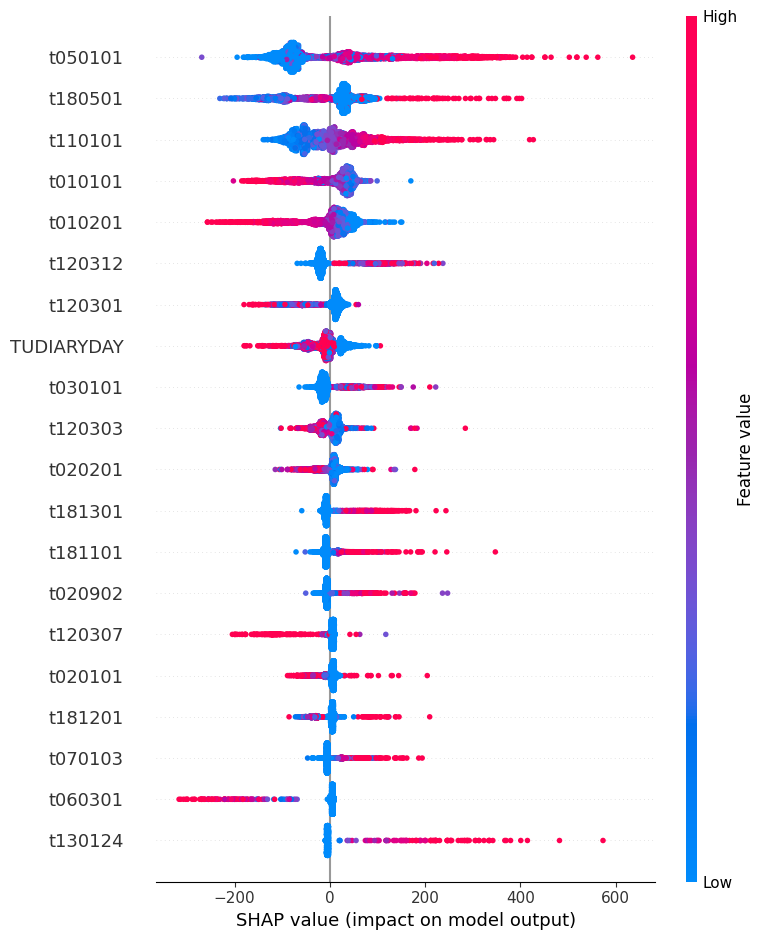

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

##### PCA

In [13]:
gbr_model = GradientBoostingRegressor(random_state=10)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_pca, y_train_pca)

y_pred = best_gbr_model.predict(X_test_pca)
y_pred2022 = best_gbr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)
mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Test MAE: 544.6237480151817
R2 Score: 0.12560851763120484
______

2022 MAE: 607.8077710950994
2022 R2 Score: 0.011371017110220927



#### Support Vector Machines (SVM)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


SVR(C=100, epsilon=1)

In [ ]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 532.7663043895228
R2 Score: 0.0705802860149275
______

2022 MAE: 641.6239966063443
2022 R2 Score: -0.16395040737864663



  0%|          | 0/100 [00:00<?, ?it/s]

##### PCA

In [10]:
svr_model = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_pca, y_train_pca)

y_pred = best_svr_model.predict(X_test_pca)
y_pred2022 = best_svr_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}

Test MAE: 532.1717752766805
R2 Score: 0.07179424709639226
______

2022 MAE: 641.3710380094252
2022 R2 Score: -0.1635228680787193



#### K-Nearest Neighbors (KNN)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}

Test MAE: 572.5463251281833
R2 Score: 0.03424820999010658
______

2022 MAE: 633.6926033644537
2022 R2 Score: -0.06659951121887642



##### PCA

In [12]:
knn_model = KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_pca)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_pca, y_train_pca)

y_pred = best_knn_model.predict(X_test_pca)
y_pred2022 = best_knn_model.predict(X_pca2022)

mae = mean_absolute_error(y_test_pca, y_pred)
r2 = r2_score(y_test_pca, y_pred)

mae_2022 = mean_absolute_error(y_pca2022, y_pred2022)
r2_2022 = r2_score(y_pca2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

Beste hyperparameters: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}

Test MAE: 571.9518334999893
R2 Score: 0.04128113723420468
______

2022 MAE: 635.7583922041046
2022 R2 Score: -0.06546525179044771



### Deep Learning Modellen

Epoch 1/100


2024-07-30 14:52:11.562315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


428/428 [==============================] - 1s 2ms/step - loss: 1136638.3750 - mae: 810.3639 - val_loss: 599958.8125 - val_mae: 588.8453
Epoch 2/100
428/428 [==============================] - 1s 1ms/step - loss: 553177.2500 - mae: 573.7775 - val_loss: 553756.1875 - val_mae: 575.3830
Epoch 3/100
428/428 [==============================] - 1s 1ms/step - loss: 526332.3125 - mae: 562.1075 - val_loss: 545328.1875 - val_mae: 571.9935
Epoch 4/100
428/428 [==============================] - 1s 1ms/step - loss: 514549.3750 - mae: 556.9858 - val_loss: 540276.9375 - val_mae: 564.7665
Epoch 5/100
428/428 [==============================] - 1s 2ms/step - loss: 506686.7500 - mae: 553.3456 - val_loss: 538704.5000 - val_mae: 559.0363
Epoch 6/100
428/428 [==============================] - 1s 1ms/step - loss: 500948.0625 - mae: 549.6611 - val_loss: 533634.4375 - val_mae: 559.0906
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 496227.2500 - mae: 547.4162 - val_loss: 532559.5625 - 

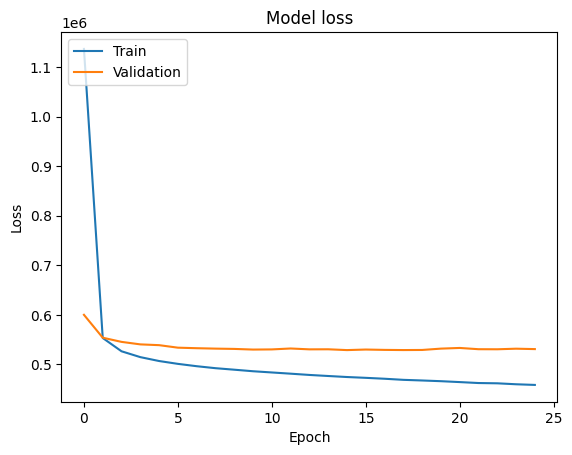

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [01:40, 38.07it/s]                       


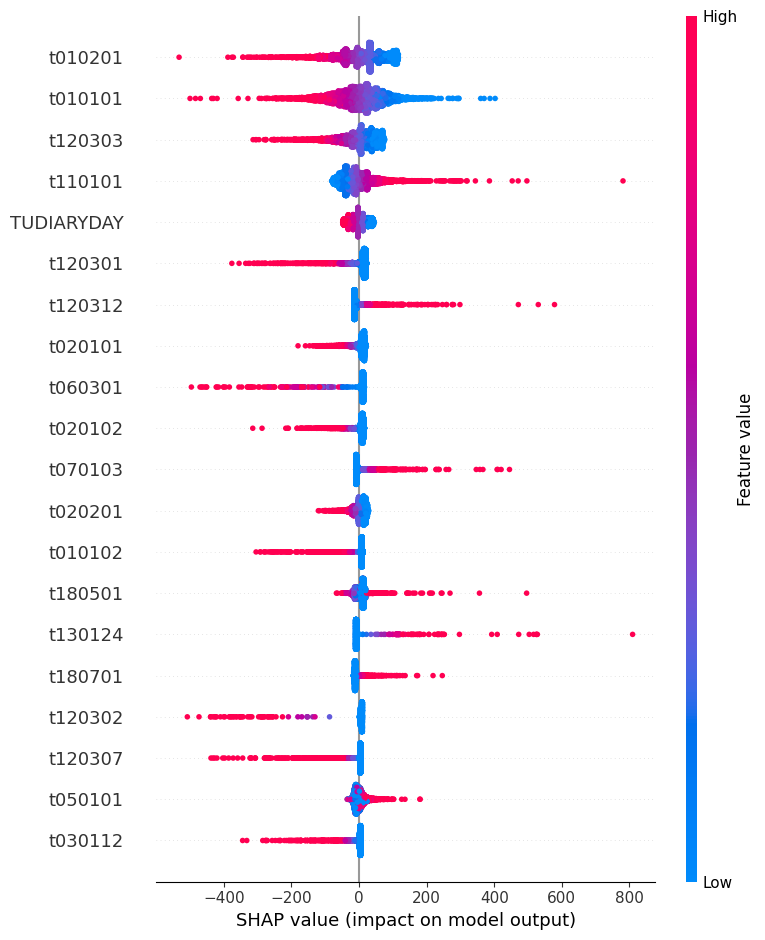

In [24]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Random Search

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10,  
    executions_per_trial=2, 
    directory='my_dir',
    project_name='income_prediction4'
)

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 00m 26s]
val_mae: 543.9100341796875

Best val_mae So Far: 541.2055969238281
Total elapsed time: 00h 05m 34s
Epoch 1/50
214/214 [==============================] - 1s 2ms/step - loss: 828238.5625 - mae: 685.2361 - val_loss: 546788.8125 - val_mae: 569.5850
Epoch 2/50
214/214 [==============================] - 0s 2ms/step - loss: 529055.8750 - mae: 558.5609 - val_loss: 534682.5625 - val_mae: 565.6034
Epoch 3/50
214/214 [==============================] - 0s 2ms/step - loss: 506397.4688 - mae: 551.7076 - val_loss: 531760.0625 - val_mae: 553.0406
Epoch 4/50
214/214 [==============================] - 0s 2ms/step - loss: 494198.4062 - mae: 544.7808 - val_loss: 529460.5000 - val_mae: 553.4504
Epoch 5/50
214/214 [==============================] - 0s 2ms/step - loss: 484150.5625 - mae: 539.3146 - val_loss: 528004.0000 - val_mae: 557.8267
Epoch 6/50
214/214 [==============================] - 0s 2ms/step - loss: 476094.4688 - mae: 536.1441 - val_loss: 522555.1250 - val_mae: 55

PermutationExplainer explainer: 4274it [02:46, 23.93it/s]                       


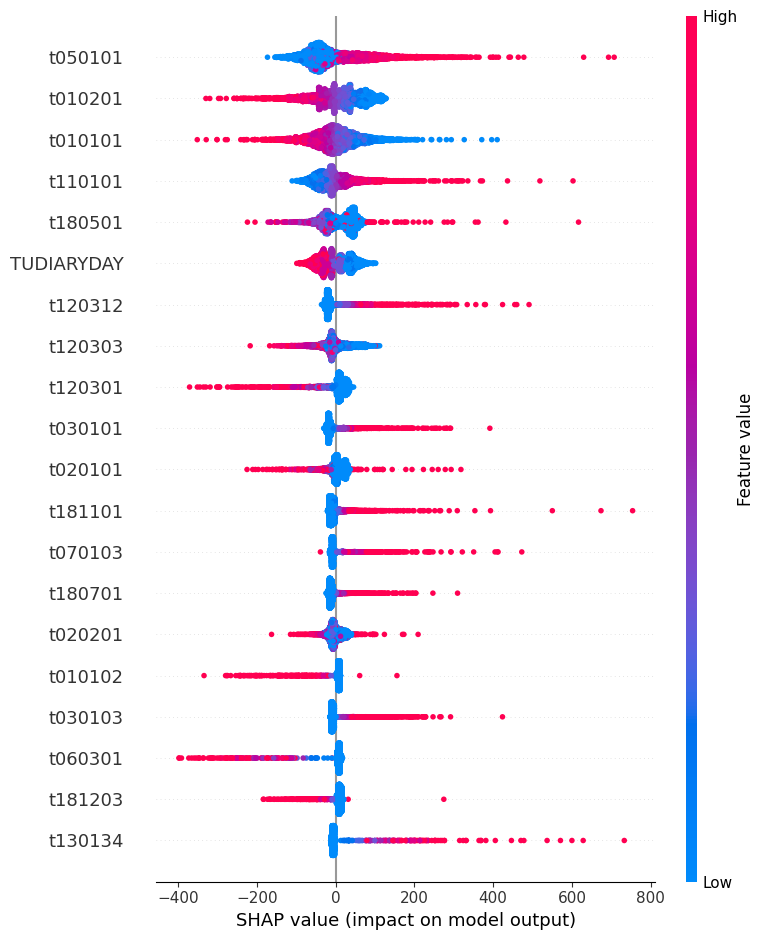

In [26]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-07-30 15:03:29,632] A new study created in memory with name: no-name-d471b658-d950-4706-91d2-077575f78a07


134/134 [==============================] - 0s 891us/step


[I 2024-07-30 15:03:47,901] Trial 0 finished with value: 570.4008175803448 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 3.9355464714823736e-05}. Best is trial 0 with value: 570.4008175803448.


134/134 [==============================] - 0s 931us/step


[I 2024-07-30 15:04:10,032] Trial 1 finished with value: 575.9980753157865 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 3.277442070728252e-05}. Best is trial 0 with value: 570.4008175803448.


134/134 [==============================] - 0s 892us/step


[I 2024-07-30 15:04:24,813] Trial 2 finished with value: 558.211077404491 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0030876355374279095}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 852us/step


[I 2024-07-30 15:04:45,081] Trial 3 finished with value: 590.2278310706034 and parameters: {'num_layers': 3, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.3989250996046968e-05}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 936us/step


[I 2024-07-30 15:05:02,766] Trial 4 finished with value: 702.6984090387562 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0006282283392497745}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 886us/step


[I 2024-07-30 15:05:20,232] Trial 5 finished with value: 563.4268183083672 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00025772003340108926}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 894us/step


[I 2024-07-30 15:05:37,678] Trial 6 finished with value: 560.5527332695681 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0004436974140611567}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 863us/step


[I 2024-07-30 15:05:54,567] Trial 7 finished with value: 596.6391009881127 and parameters: {'num_layers': 1, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.00037742364326197553}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 865us/step


[I 2024-07-30 15:06:16,254] Trial 8 finished with value: 568.2188255805621 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 3.764214497241503e-05}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 770us/step


[I 2024-07-30 15:06:32,629] Trial 9 finished with value: 561.5088324618813 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0001205814327080616}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:06:46,913] Trial 10 finished with value: 590.5910198781777 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.006875530360736709}. Best is trial 2 with value: 558.211077404491.


134/134 [==============================] - 0s 790us/step


[I 2024-07-30 15:07:03,259] Trial 11 finished with value: 550.8829901296955 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0027898695173185365}. Best is trial 11 with value: 550.8829901296955.


134/134 [==============================] - 0s 809us/step


[I 2024-07-30 15:07:16,645] Trial 12 finished with value: 549.921896030668 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0037103890241402876}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 798us/step


[I 2024-07-30 15:07:33,599] Trial 13 finished with value: 552.6967365148301 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0017911782734958523}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 578us/step


[I 2024-07-30 15:07:39,832] Trial 14 finished with value: 756.8373705204973 and parameters: {'num_layers': 1, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.008664051732289003}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 767us/step


[I 2024-07-30 15:07:53,662] Trial 15 finished with value: 794.4643509107536 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0014997138383034782}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 982us/step


[I 2024-07-30 15:08:10,740] Trial 16 finished with value: 552.772972149071 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.002949078788423395}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:08:29,292] Trial 17 finished with value: 702.3674550846581 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0010345718474137036}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:08:47,204] Trial 18 finished with value: 562.6371907496257 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0042372114229000295}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 658us/step


[I 2024-07-30 15:09:04,885] Trial 19 finished with value: 926.3644725145972 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00015949368043392928}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 638us/step


[I 2024-07-30 15:09:17,521] Trial 20 finished with value: 833.7433421109909 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0008835011174605303}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:09:33,326] Trial 21 finished with value: 550.4520354695748 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0018160062096705038}. Best is trial 12 with value: 549.921896030668.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:09:55,298] Trial 22 finished with value: 546.2813109939115 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.001998069042324672}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 972us/step


[I 2024-07-30 15:10:11,561] Trial 23 finished with value: 547.8553763681202 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00476959250983883}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:10:27,153] Trial 24 finished with value: 555.5522471661861 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.005670993788168719}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:10:48,358] Trial 25 finished with value: 551.9374174274184 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.008331297265098929}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:11:05,380] Trial 26 finished with value: 561.1633572509465 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.003819182417609541}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:11:25,335] Trial 27 finished with value: 792.0299285825377 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0011577339195872826}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:11:46,531] Trial 28 finished with value: 549.1056499201059 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0021910390639208813}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:12:07,528] Trial 29 finished with value: 819.1327852222989 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0006784116031531612}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:12:28,828] Trial 30 finished with value: 556.4295808874515 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.001992431427381414}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 974us/step


[I 2024-07-30 15:12:40,844] Trial 31 finished with value: 556.9475951679926 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00500702390764302}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:12:59,411] Trial 32 finished with value: 555.1811549108547 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.00240153431208999}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 976us/step


[I 2024-07-30 15:13:11,201] Trial 33 finished with value: 550.0642050960084 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.004531624560926557}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:13:32,821] Trial 34 finished with value: 548.7822868746046 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001195888320284283}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 979us/step


[I 2024-07-30 15:13:54,702] Trial 35 finished with value: 555.1450628741385 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.001304177120456875}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:14:20,510] Trial 36 finished with value: 572.3451793865808 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.000662884759203013}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:14:46,229] Trial 37 finished with value: 568.359043736807 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 6.477495555417379e-05}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 895us/step


[I 2024-07-30 15:15:07,448] Trial 38 finished with value: 1026.649537438481 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.1823411814175505e-05}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:15:28,921] Trial 39 finished with value: 563.316069202633 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0002790440846087637}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:15:51,634] Trial 40 finished with value: 1025.5782499979966 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 2.0908703535027785e-05}. Best is trial 22 with value: 546.2813109939115.


134/134 [==============================] - 0s 914us/step


[I 2024-07-30 15:16:11,436] Trial 41 finished with value: 545.7401889029517 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0030098851705952865}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 771us/step


[I 2024-07-30 15:16:29,473] Trial 42 finished with value: 548.9522292458757 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0020945406204063315}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:16:50,339] Trial 43 finished with value: 688.0185796610099 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0004916859900511939}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:16:59,228] Trial 44 finished with value: 564.5426774763934 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.006632429158062481}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 804us/step


[I 2024-07-30 15:17:17,121] Trial 45 finished with value: 552.429214576241 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0032482749205066585}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 921us/step


[I 2024-07-30 15:17:35,681] Trial 46 finished with value: 614.9783397281931 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0008271633035456762}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 871us/step


[I 2024-07-30 15:17:54,347] Trial 47 finished with value: 550.7444637541054 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0013854316884452076}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:18:01,542] Trial 48 finished with value: 558.68281910181 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0025742688145211036}. Best is trial 41 with value: 545.7401889029517.


134/134 [==============================] - 0s 819us/step


[I 2024-07-30 15:18:20,307] Trial 49 finished with value: 617.8090636901355 and parameters: {'num_layers': 2, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0016351546106108672}. Best is trial 41 with value: 545.7401889029517.


FrozenTrial(number=41, state=TrialState.COMPLETE, values=[545.7401889029517], datetime_start=datetime.datetime(2024, 7, 30, 15, 15, 51, 636026), datetime_complete=datetime.datetime(2024, 7, 30, 15, 16, 11, 436327), params={'num_layers': 2, 'num_units': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0030098851705952865}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=41, value=None)
133/133 [==============================] - 0s 1ms/step


Test MAE: 550.0294318156887
R2 Score: 0.08372459815438482

______
2022 MAE: 627.6208557166458
2022 R2 Score: -0.05835759748584657


PermutationExplainer explainer: 4274it [01:54, 34.09it/s]                       


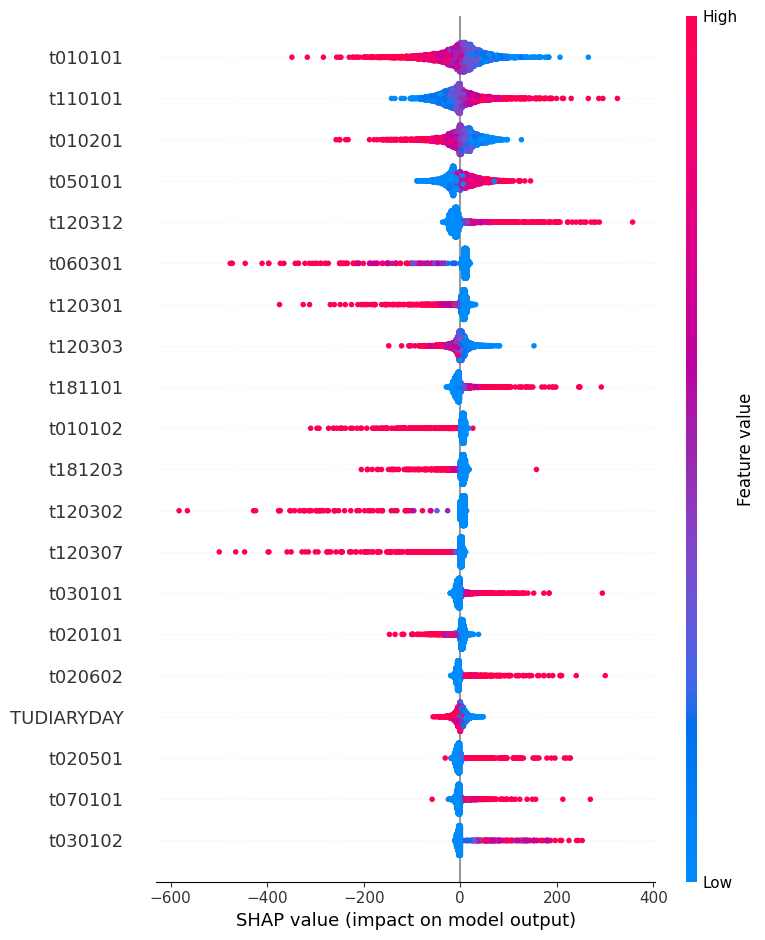

In [28]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### 1D Convolutional Neural Network

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 4s 8ms/step - loss: 683018.4375 - mae: 638.0670 - val_loss: 537823.2500 - val_mae: 578.7465
Epoch 2/100
428/428 [==============================] - 3s 7ms/step - loss: 545979.5625 - mae: 585.0474 - val_loss: 526694.2500 - val_mae: 570.5143
Epoch 3/100
428/428 [==============================] - 3s 7ms/step - loss: 529820.7500 - mae: 576.6729 - val_loss: 516143.5625 - val_mae: 574.7674
Epoch 4/100
428/428 [==============================] - 3s 7ms/step - loss: 515910.6875 - mae: 567.6318 - val_loss: 508548.2812 - val_mae: 554.6534
Epoch 5/100
428/428 [==============================] - 3s 8ms/step - loss: 507109.9062 - mae: 561.1422 - val_loss: 508853.9375 - val_mae: 562.4949
Epoch 6/100
428/428 [==============================] - 3s 8ms/step - loss: 504023.5625 - mae: 559.6296 - val_loss: 510348.6562 - val_mae: 556.8341
Epoch 7/100
428/428 [==============================] - 3s 8ms/step - loss: 499193.3750 - mae: 556.9835 - val_loss: 511

In [30]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-07-30 15:21:57,335] A new study created in memory with name: no-name-e950b8ed-24df-4835-bbfd-6a7c9026a3f5


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 15:25:00,270] Trial 0 finished with value: 1018.0597673532998 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.3828748695320904, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 1.1858115553133015e-05}. Best is trial 0 with value: 1018.0597673532998.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 15:33:43,001] Trial 1 finished with value: 1012.4293128643756 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.0452442669200781, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 1.2930960203988611e-05}. Best is trial 1 with value: 1012.4293128643756.


134/134 [==============================] - 2s 13ms/step


[I 2024-07-30 15:54:19,913] Trial 2 finished with value: 574.8671913301774 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.332541789928128, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 3.177475684644264e-05}. Best is trial 2 with value: 574.8671913301774.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 15:55:23,976] Trial 3 finished with value: 554.4736751950275 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0260442521714781, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0002132855794110922}. Best is trial 3 with value: 554.4736751950275.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:57:51,803] Trial 4 finished with value: 677.70556165085 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.11529668008280974, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.001270669262768423}. Best is trial 3 with value: 554.4736751950275.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 15:59:53,062] Trial 5 finished with value: 551.6784011139346 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.09799761051527822, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.005720883263002783}. Best is trial 5 with value: 551.6784011139346.


134/134 [==============================] - 4s 27ms/step


[I 2024-07-30 16:27:06,918] Trial 6 finished with value: 556.3988417844016 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.044071951390674435, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 6.0708023896190516e-05}. Best is trial 5 with value: 551.6784011139346.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 16:30:55,432] Trial 7 finished with value: 979.0063941429562 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.108259574277631, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 1.9017395233890837e-05}. Best is trial 5 with value: 551.6784011139346.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 16:33:06,191] Trial 8 finished with value: 592.6962745111931 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.41086769271745405, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.003503262280336927}. Best is trial 5 with value: 551.6784011139346.


134/134 [==============================] - 2s 14ms/step


[I 2024-07-30 16:47:21,764] Trial 9 finished with value: 539.2254273379215 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.22406554192563705, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0001315695770457824}. Best is trial 9 with value: 539.2254273379215.


134/134 [==============================] - 2s 18ms/step


[I 2024-07-30 17:07:24,310] Trial 10 finished with value: 537.803105740341 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.22732883411066185, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.00018979066817814013}. Best is trial 10 with value: 537.803105740341.


134/134 [==============================] - 3s 21ms/step


[I 2024-07-30 17:28:08,601] Trial 11 finished with value: 554.103589394702 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.23107749236660302, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.00023849433008109176}. Best is trial 10 with value: 537.803105740341.


134/134 [==============================] - 2s 15ms/step


[I 2024-07-30 17:42:32,938] Trial 12 finished with value: 555.7384644925687 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.23294113976422337, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00010188699318286223}. Best is trial 10 with value: 537.803105740341.


134/134 [==============================] - 2s 17ms/step


[I 2024-07-30 17:51:52,724] Trial 13 finished with value: 538.0183619867698 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.29436075648051807, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0009079584817599196}. Best is trial 10 with value: 537.803105740341.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 18:06:08,483] Trial 14 finished with value: 528.3996203877533 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4998393321755505, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0007440225482432098}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 18:10:41,505] Trial 15 finished with value: 551.1109186774124 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.48795725833067105, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.0006885319704706393}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 18:13:06,325] Trial 16 finished with value: 539.1178214815096 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.1670554414321536, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00042864293734630866}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 12ms/step


[I 2024-07-30 18:17:14,769] Trial 17 finished with value: 551.8085186517952 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.46455160246305743, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.002215435131676093}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 8ms/step


[I 2024-07-30 18:24:09,938] Trial 18 finished with value: 543.6905078296406 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.30273501744553044, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00047085143865206383}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 14ms/step


[I 2024-07-30 18:29:53,068] Trial 19 finished with value: 546.9148542550827 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.18175701269009517, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0015766376860027347}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 18:37:23,448] Trial 20 finished with value: 534.2814361733763 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3759876431571735, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.009818919888918828}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 18:41:48,439] Trial 21 finished with value: 537.3556028644803 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4013668749518159, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.007506521829420582}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 18:47:35,873] Trial 22 finished with value: 533.2514971649576 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4289359705942551, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.009632237886625601}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 18:53:32,050] Trial 23 finished with value: 532.9052876589082 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4470584560557536, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.004113829834187047}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 18:59:04,736] Trial 24 finished with value: 529.4619901996057 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4444512595787959, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.003911108787124996}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 19:01:33,445] Trial 25 finished with value: 555.0774548718099 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4637874619677816, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.003790342287533828}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 16ms/step


[I 2024-07-30 19:18:14,139] Trial 26 finished with value: 592.7459056777293 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.49335799681262377, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0026616745215725986}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 19:22:34,737] Trial 27 finished with value: 540.9539301776886 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.44385816181265286, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0015021130715914958}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 11ms/step


[I 2024-07-30 19:27:13,893] Trial 28 finished with value: 533.5389266463841 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.36026615921938826, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.004846829669508254}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 19:31:54,622] Trial 29 finished with value: 583.4311633372201 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.33860825122827254, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.000819968035477818}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 12ms/step


[I 2024-07-30 19:38:26,711] Trial 30 finished with value: 539.3090781850931 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.44218137744519176, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0019884393757197763}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 19:42:23,341] Trial 31 finished with value: 544.2789882374424 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4193857779123419, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.009890037681511515}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 19:49:12,748] Trial 32 finished with value: 539.3488805459953 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4980598709012229, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.00583674158851184}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 19:55:47,075] Trial 33 finished with value: 536.6163679680589 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.43444043358090634, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0039574426792254}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 20:00:35,453] Trial 34 finished with value: 537.0504162765225 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3925959507120466, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0032343317508138373}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 20:08:14,050] Trial 35 finished with value: 592.8246481426801 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.4717136698418406, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.006240445689799191}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 20:13:46,099] Trial 36 finished with value: 533.8131963797236 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.35580317249584176, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0010803689662251584}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 20:14:36,381] Trial 37 finished with value: 553.1381445132544 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3051767313637803, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0005764673436188588}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 20:18:18,127] Trial 38 finished with value: 542.6269644207877 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.45249403432599294, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.001958845405652062}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 20:20:24,755] Trial 39 finished with value: 592.7235105604962 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.42068409744037893, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.007791554815319429}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 16ms/step


[I 2024-07-30 20:26:23,895] Trial 40 finished with value: 548.7975004515781 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.37672762000548754, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004500002663417051}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 11ms/step


[I 2024-07-30 20:28:51,928] Trial 41 finished with value: 563.7002950636529 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.359617987336754, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.005001990223234256}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 20:33:05,699] Trial 42 finished with value: 542.6504076435037 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4775495616287586, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.002841159891583167}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 20:36:58,832] Trial 43 finished with value: 542.9883183846662 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.4284391499607139, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.006692877190808639}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 20:39:03,764] Trial 44 finished with value: 587.9293840085776 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.2717699299452461, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 1.042051221249915e-05}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-30 20:45:45,831] Trial 45 finished with value: 572.0487417669317 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.39031216269511426, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 6.068685687794387e-05}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 12ms/step


[I 2024-07-30 20:49:50,724] Trial 46 finished with value: 536.1086580057578 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.00565966446202637, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.004671879110258852}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 20:59:11,435] Trial 47 finished with value: 732.5324723666295 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.40961955939434347, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.00034071471442272334}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 21:01:50,907] Trial 48 finished with value: 547.7365132276063 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3371681795228841, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0013672467154467731}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 21:06:09,963] Trial 49 finished with value: 535.6402048869588 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.46257840368850073, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.0024339272493516194}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 2s 11ms/step


[I 2024-07-30 21:15:57,072] Trial 50 finished with value: 577.9784797713095 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.4982631489147562, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 1.9975750528941666e-05}. Best is trial 14 with value: 528.3996203877533.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 21:20:54,741] Trial 51 finished with value: 527.4889745091143 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3521872274245862, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012608683009278218}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 7ms/step


[I 2024-07-30 21:25:12,940] Trial 52 finished with value: 534.112048965533 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.3573581183471515, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001132166962804184}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 9ms/step


[I 2024-07-30 21:29:06,715] Trial 53 finished with value: 541.3187739695203 and parameters: {'num_conv_layers': 3, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.32142327365134465, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0034554398974370308}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-30 21:32:21,492] Trial 54 finished with value: 536.221600703403 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.44704569152842116, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.008555822000276174}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 21:34:34,631] Trial 55 finished with value: 528.8886975616604 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2554448791404559, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0016989112485851893}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 21:37:04,785] Trial 56 finished with value: 546.5340102628129 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.18433714927690192, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0017542049484016763}. Best is trial 51 with value: 527.4889745091143.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 21:40:17,838] Trial 57 finished with value: 516.7624005511549 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2582528441588495, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0006213267272764223}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 21:43:30,748] Trial 58 finished with value: 540.8761332159892 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2643800390698873, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.000675342651578887}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 21:48:20,553] Trial 59 finished with value: 581.9656377429636 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.14336548361635088, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00029666162914658025}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 21:50:47,784] Trial 60 finished with value: 529.2753018663774 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.21160489216001419, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0010463423755372498}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 21:54:00,800] Trial 61 finished with value: 536.28817364197 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20556475553406983, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0009171971882527711}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 21:56:03,788] Trial 62 finished with value: 525.8938154822471 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.24599876465583206, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0004956827919572905}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 21:58:06,142] Trial 63 finished with value: 527.3510040057339 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2769353036423739, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0005454126335465327}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:00:07,992] Trial 64 finished with value: 554.6731420546339 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.24202660064935855, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.00046996416187484574}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:02:11,823] Trial 65 finished with value: 561.2230339786986 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.20917887560420217, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0005809535369432323}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:05:47,117] Trial 66 finished with value: 545.168410536045 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.263917458400624, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0001813410473263636}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:07:49,098] Trial 67 finished with value: 541.5180782323204 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.28805560994959156, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0003209407545578541}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 22:11:03,287] Trial 68 finished with value: 528.0655511935623 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2162311584041635, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0007945696620123736}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:12:52,370] Trial 69 finished with value: 548.7116539962549 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.06819862648182351, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0007506513112585734}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:14:55,724] Trial 70 finished with value: 533.5572196490776 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.255375902217896, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00040156239390986155}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:17:11,992] Trial 71 finished with value: 533.1609623668903 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2236770004075735, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.000994679790904449}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 22:20:08,748] Trial 72 finished with value: 532.0633140325781 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2789828286726114, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0006254074992780075}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:22:09,586] Trial 73 finished with value: 543.7915235892198 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.19571983376631996, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0005213454998615329}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:25:02,039] Trial 74 finished with value: 527.4078450691391 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.15683149358036325, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001262146164808498}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:26:30,919] Trial 75 finished with value: 544.3998555412087 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.15910420207189846, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0013130704914826826}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:29:19,317] Trial 76 finished with value: 538.1135663709188 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.13657875529661023, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0007819273464510419}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 6ms/step


[I 2024-07-30 22:33:16,230] Trial 77 finished with value: 592.5056988706796 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.2478477307281858, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.001566478972452029}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 22:36:43,206] Trial 78 finished with value: 559.5098832209842 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3101292453104075, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0003728018635022105}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:38:51,249] Trial 79 finished with value: 537.2643308455845 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.08679266389295187, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0002460418037632329}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:40:51,743] Trial 80 finished with value: 519.9701657373699 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.22644330591676404, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0012416878265845502}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:42:28,993] Trial 81 finished with value: 544.712993485879 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2277875908279772, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0008185695730615957}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 22:45:07,557] Trial 82 finished with value: 527.0873365429562 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16772023802841407, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0011881758290204158}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:46:39,707] Trial 83 finished with value: 533.7418840249355 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16775242833211407, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0011794351682467188}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 22:50:30,173] Trial 84 finished with value: 533.1349933491606 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.11128171851316346, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0005278733652557331}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 22:53:29,288] Trial 85 finished with value: 532.9629480696394 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12821078125328428, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0009047515332811446}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:55:55,361] Trial 86 finished with value: 523.7142223828096 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.18697120487430036, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0006811528942367922}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 22:58:21,505] Trial 87 finished with value: 540.2508794761088 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.18262090894941993, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0006603762147152007}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:00:26,750] Trial 88 finished with value: 533.063512857742 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.16892464760560608, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00210947183295125}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 23:02:49,254] Trial 89 finished with value: 573.4309810345071 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'tanh', 'dropout_rate': 0.2380367782254535, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.00045512744627624046}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 23:05:47,678] Trial 90 finished with value: 532.3537371159827 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.15436099768665762, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0013152456795216306}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:07:53,950] Trial 91 finished with value: 553.4702290545999 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1961101433267972, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0007143666321366374}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 23:09:49,110] Trial 92 finished with value: 540.0487378819932 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2155292802579738, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0008943911259057766}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 23:14:37,402] Trial 93 finished with value: 534.4339311164597 and parameters: {'num_conv_layers': 3, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.19307551522378608, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0010500733615428296}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 10ms/step


[I 2024-07-30 23:24:01,438] Trial 94 finished with value: 529.0762883751871 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2794549958942683, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0005444514733505285}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 23:27:38,280] Trial 95 finished with value: 552.3860238410706 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.17455909961986787, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0002712237247561343}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:31:27,815] Trial 96 finished with value: 525.0491115580156 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.22297725767118623, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0014919942800142273}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:32:26,507] Trial 97 finished with value: 541.7201805093678 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.22048642674484392, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.001382120546522563}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 23:35:18,693] Trial 98 finished with value: 531.5861216848683 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.24128333621628248, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0024135052944822526}. Best is trial 57 with value: 516.7624005511549.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 23:40:26,787] Trial 99 finished with value: 532.8466661165871 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.29409882149824057, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0016786813747001292}. Best is trial 57 with value: 516.7624005511549.


FrozenTrial(number=57, state=TrialState.COMPLETE, values=[516.7624005511549], datetime_start=datetime.datetime(2024, 7, 30, 21, 37, 4, 786304), datetime_complete=datetime.datetime(2024, 7, 30, 21, 40, 17, 838433), params={'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2582528441588495, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.0006213267272764223}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribu

In [31]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 1s 5ms/step


Test MAE: 530.9481877903634
R2 Score: 0.14726892485243614

______
2022 MAE: 603.5659768302013
2022 R2 Score: -0.03477892521623538


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


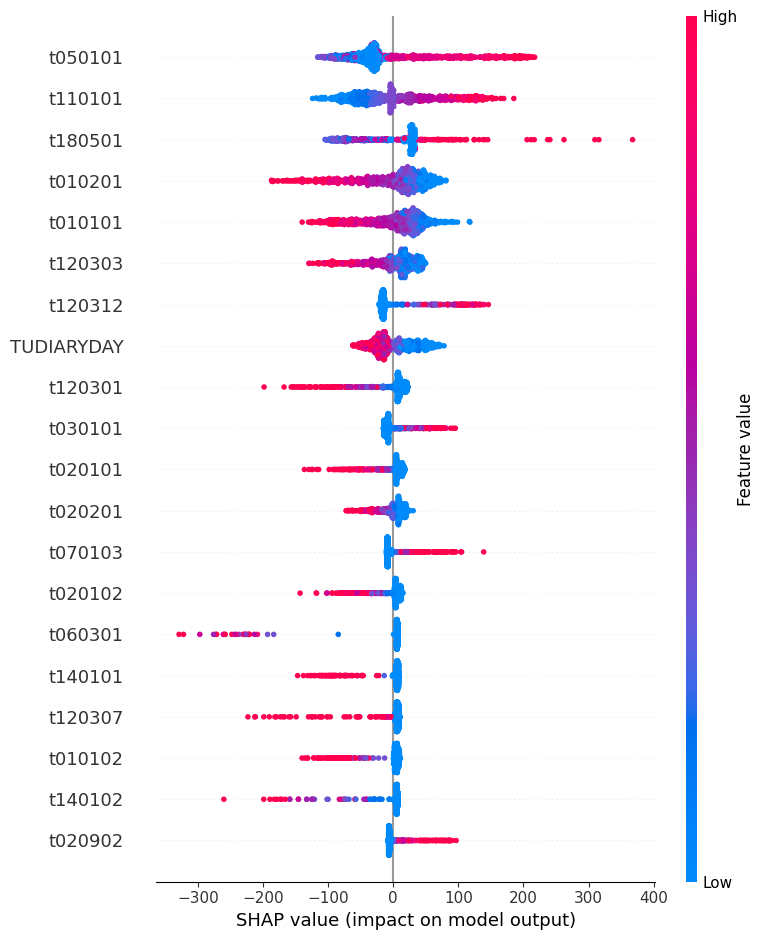

In [32]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)